In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Import Modul Keras yang sering error jika lupa
from tensorflow.keras import layers, models, optimizers
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# --- OPTIMASI: COPY DATA KE LOKAL (Agar Cepat) ---
print("\n--- Menyiapkan Data ---")
source_dir = '/content/drive/MyDrive/FishImgDataset' # Pastikan path ini benar di Drive Anda
local_dir = '/content/fish_data'                     # Path tujuan di Colab

# Cek apakah data sudah ada di local (supaya tidak copy ulang kalau di-run 2x)
if not os.path.exists(local_dir):
    print("Sedang menyalin data dari Drive ke Local Runtime...")
    print("Proses ini butuh 1-3 menit, tapi training nanti akan sangat cepat!")
    shutil.copytree(source_dir, local_dir)
    print("Selesai menyalin! Data siap digunakan.")
else:
    print("Data sudah ada di local runtime. Siap lanjut.")

# Set path ke folder lokal
train_dir = os.path.join(local_dir, 'train')
val_dir = os.path.join(local_dir, 'val')
test_dir = os.path.join(local_dir, 'test')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Menyiapkan Data ---
Data sudah ada di local runtime. Siap lanjut.


In [3]:
# --- KONFIGURASI PIPELINE ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32 # Standar GPU T4
AUTOTUNE = tf.data.AUTOTUNE

print("--- Loading Datasets ---")

# Add a robust check for data directories and force re-copy if incomplete
# This check ensures that 'train', 'val', and 'test' subdirectories exist.
# If any are missing, it indicates an incomplete copy, and a re-copy is needed.
if not os.path.exists(train_dir) or not os.path.exists(val_dir) or not os.path.exists(test_dir):
    print(f"One or more data directories ({train_dir}, {val_dir}, {test_dir}) not found or incomplete.")
    print(f"Attempting to remove existing {local_dir} and re-copy data from {source_dir}.")
    import shutil
    try:
        if os.path.exists(local_dir):
            shutil.rmtree(local_dir)
            print(f"  Successfully removed existing (incomplete) folder: {local_dir}")

        if os.path.exists(source_dir):
            print("  Starting fresh copy...")
            shutil.copytree(source_dir, local_dir)
            print("  Re-copy successful! All required directories should now be present.")
        else:
            raise FileNotFoundError(f"Source directory {source_dir} not found. Please ensure your Google Drive path is correct and mounted.")
    except Exception as e:
        print(f"Error during data re-copy: {e}")
        raise # Re-raise if copy fails to prevent further errors
else:
    print("Data directories verified. Proceeding with dataset loading.")

# 1. Load Data
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True, label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False, label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False, label_mode='categorical'
)

class_names = train_ds.class_names
print(f"\nJumlah Kelas: {len(class_names)}")

# 2. Fungsi Preprocessing (MobileNetV2 Standard: -1 s/d 1)
def preprocess(image, label):
    return tf.keras.applications.mobilenet_v2.preprocess_input(image), label

# 3. Optimasi Pipeline (TANPA .cache() AGAR TIDAK CRASH RAM)
# Kita gunakan prefetch saja. Karena data sudah di local disk, ini sudah sangat cepat.
train_ds = train_ds.map(preprocess).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(preprocess).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(preprocess).prefetch(buffer_size=AUTOTUNE)

# 4. Layer Augmentasi (Akan dipasang di dalam model)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

print("Pipeline Siap (Mode Stabil & Cepat).")

--- Loading Datasets ---
One or more data directories (/content/fish_data/train, /content/fish_data/val, /content/fish_data/test) not found or incomplete.
Attempting to remove existing /content/fish_data and re-copy data from /content/drive/MyDrive/FishImgDataset.
  Successfully removed existing (incomplete) folder: /content/fish_data
  Starting fresh copy...
  Re-copy successful! All required directories should now be present.
Found 8819 files belonging to 31 classes.
Found 2751 files belonging to 31 classes.
Found 1761 files belonging to 31 classes.

Jumlah Kelas: 31
Pipeline Siap (Mode Stabil & Cepat).


In [4]:
print("--- Menghitung Class Weights ---")

# Hitung manual jumlah file
train_labels = []
# Kita scan folder local yang sudah di-copy
for label in class_names:
    class_path = os.path.join(train_dir, label)
    if os.path.exists(class_path):
        count = len(os.listdir(class_path))
        idx = class_names.index(label)
        train_labels.extend([idx] * count)

# Hitung Bobot menggunakan sklearn
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights_dict = dict(enumerate(class_weights_vals))
print("✅ Class Weights berhasil dihitung.")

--- Menghitung Class Weights ---
✅ Class Weights berhasil dihitung.


In [5]:
# --- DEFINISI MODEL SCRATCH (FIXED) ---
def create_scratch_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # 1. Augmentasi
    x = data_augmentation(inputs)

    # --- BLOCK 1 ---
    x = layers.Conv2D(32, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x) # Fixed syntax
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # --- BLOCK 2 ---
    x = layers.Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # --- BLOCK 3 ---
    x = layers.Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # --- BLOCK 4 (Deep) ---
    x = layers.Conv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # --- CLASSIFIER ---
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x) # Dropout agak besar untuk mencegah overfitting

    x = layers.Dense(128, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    outputs = layers.Dense(len(class_names), activation='softmax')(x)

    model = models.Model(inputs, outputs, name="CNN_From_Scratch_Fixed")
    return model

# Setup Model
model_scratch = create_scratch_model()

# Compile (Learning Rate 0.0001 agar stabil)
model_scratch.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

print("\n--- Mulai Training Model Scratch ---")
history_scratch = model_scratch.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    class_weight=class_weights_dict,
    callbacks=callbacks
)


--- Mulai Training Model Scratch ---
Epoch 1/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 63s 184ms/step - accuracy: 0.0678 - loss: 3.6105 - val_accuracy: 0.0752 - val_loss: 3.3120 - learning_rate: 1.0000e-04
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 48s 173ms/step - accuracy: 0.1110 - loss: 3.2665 - val_accuracy: 0.0520 - val_loss: 6.1907 - learning_rate: 1.0000e-04
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 46s 168ms/step - accuracy: 0.1361 - loss: 3.1785 - val_accuracy: 0.0491 - val_loss: 7.5706 - learning_rate: 1.0000e-04
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 48s 172ms/step - accuracy: 0.1386 - loss: 3.1040 - val_accuracy: 0.0542 - val_loss: 8.1314 - learning_rate: 5.0000e-05
Epoch 5/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 83s 175ms/step - accuracy: 0.1438 - loss: 3.0603 - val_accuracy: 0.0494 - val_loss: 9.3213 - learning_rate: 5.0000e-05
Epoch 6/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 48s 172ms/step - accuracy: 0.1623 - loss: 3.0438 - val_accuracy: 0.0538 - val_loss: 9.2041 - learning_rate: 2.5000e-05


In [6]:
# --- MODEL TRANSFER LEARNING ---

# Load Base Model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False # Bekukan bobot bawaan

# Bangun Arsitektur
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model_tl = models.Model(inputs, outputs, name="MobileNetV2_Transfer")

model_tl.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

print("\n--- Mulai Training Model Transfer Learning ---")
history_tl = model_tl.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Mulai Training Model Transfer Learning ---
Epoch 1/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 53s 166ms/step - accuracy: 0.1789 - loss: 3.0345 - val_accuracy: 0.5162 - val_loss: 1.7656 - learning_rate: 0.0010
Epoch 2/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 44s 161ms/step - accuracy: 0.4533 - loss: 1.8843 - val_accuracy: 0.5914 - val_loss: 1.4161 - learning_rate: 0.0010
Epoch 3/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 82s 158ms/step - accuracy: 0.5190 - loss: 1.6455 - val_accuracy: 0.5522 - val_loss: 1.4436 - learning_rate: 0.0010
Epoch 4/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 82s 158ms/step - accuracy: 0.5418 - loss: 1.5199 - val_accuracy: 0.5758 - val_loss: 1.3749 - learning_rate: 0.0010
Epoch 5/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 46s 167ms/step - accuracy: 0.5647 - loss: 1.4181 - val_accuracy: 0.6249 - val_loss: 1.2316 - learning_rate: 0.0010
Epoch 6/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 44s 158ms/step - accuracy: 0.5857 - loss: 1.3706 - val_accuracy: 0.6252 - val_loss: 1.20

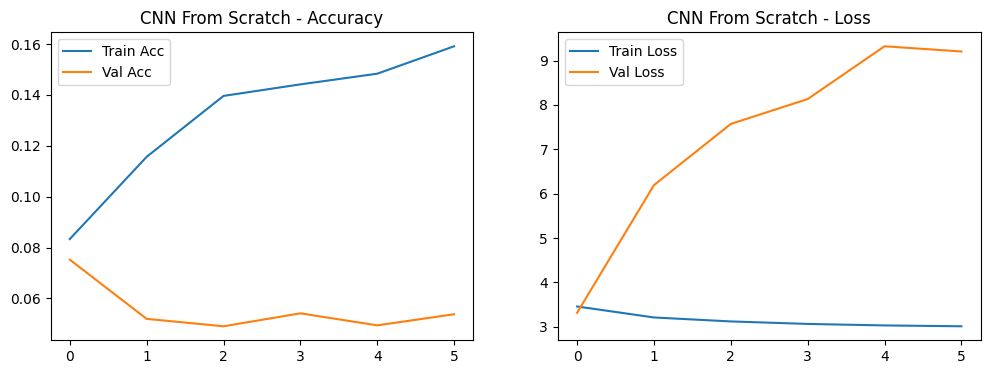

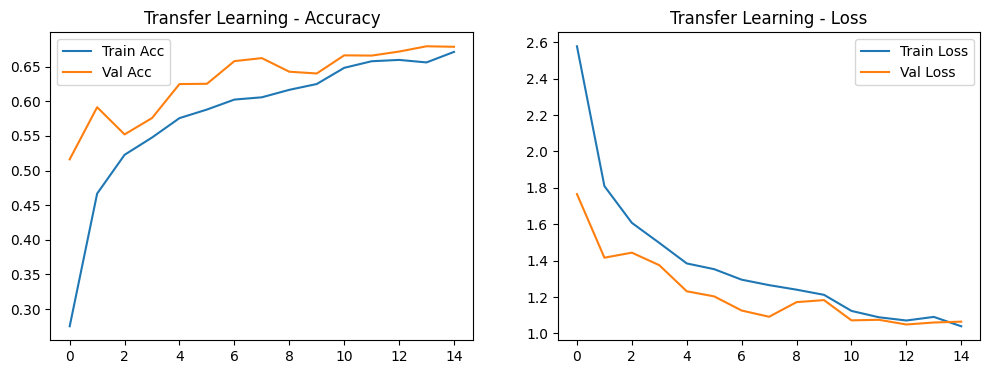


--- Evaluasi Final pada Data TEST ---
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.6547 - loss: 1.1237
Test Accuracy: 68.65%
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step

Classification Report:
                       precision    recall  f1-score   support

               Bangus       0.42      0.50      0.46        34
        Big Head Carp       0.59      0.47      0.52        43
   Black Spotted Barb       0.75      0.53      0.62        40
              Catfish       0.76      0.56      0.65        62
       Climbing Perch       0.57      0.53      0.55        30
 Fourfinger Threadfin       0.32      0.92      0.47        38
       Freshwater Eel       0.81      0.80      0.81        55
       Glass Perchlet       0.89      0.71      0.79        77
                 Goby       0.73      0.65      0.69       124
            Gold Fish       0.98      1.00      0.99        41
              Gourami       0.84      0.86      0.85        63
           Grass Carp       0.95      0.58

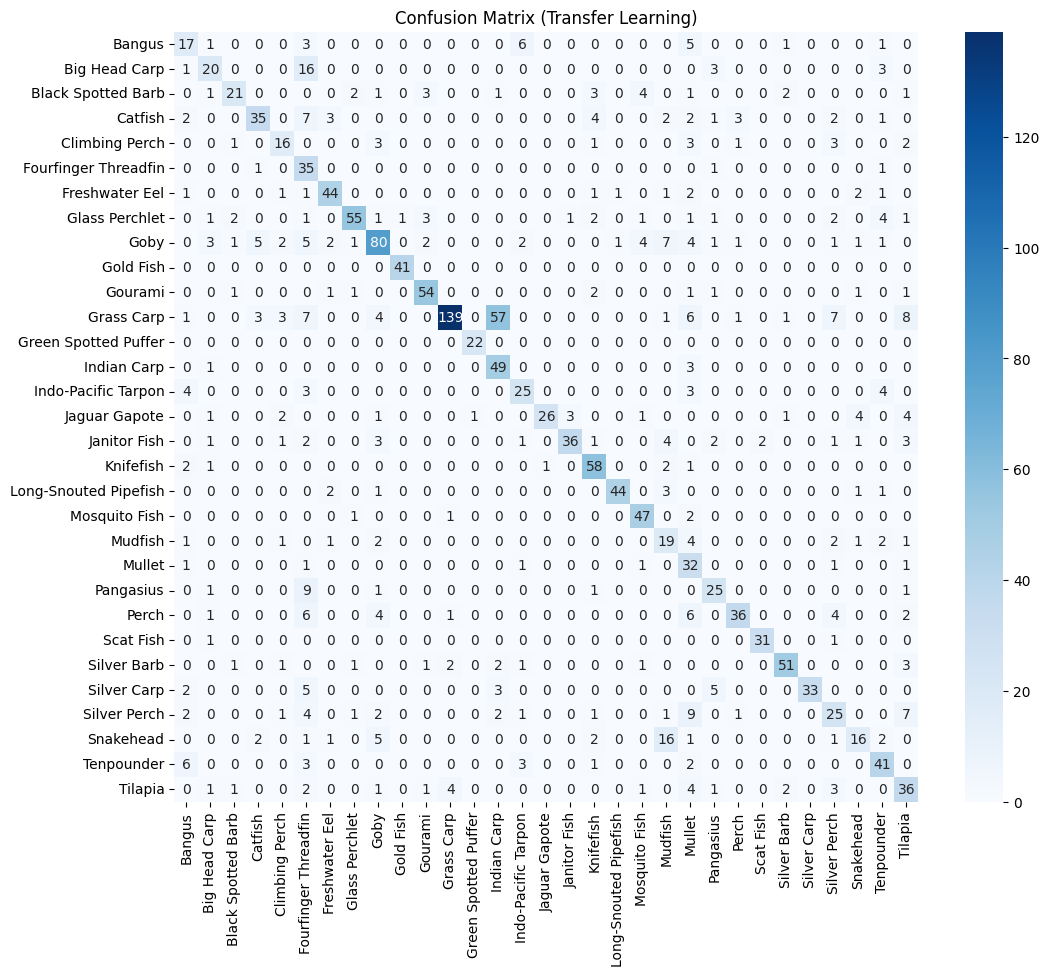

In [7]:
# Fungsi Plot
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

# Plot keduanya
plot_history(history_scratch, "CNN From Scratch")
plot_history(history_tl, "Transfer Learning")

# Evaluasi Final (Gunakan Model Terbaik / TL)
print("\n--- Evaluasi Final pada Data TEST ---")
model_best = model_tl # Biasanya TL lebih bagus, kita pakai untuk evaluasi final
test_loss, test_acc = model_best.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Confusion Matrix
y_pred_probs = model_best.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Transfer Learning)")
plt.show()

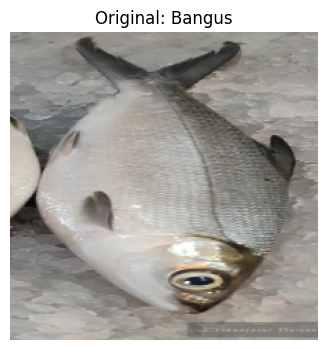

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step


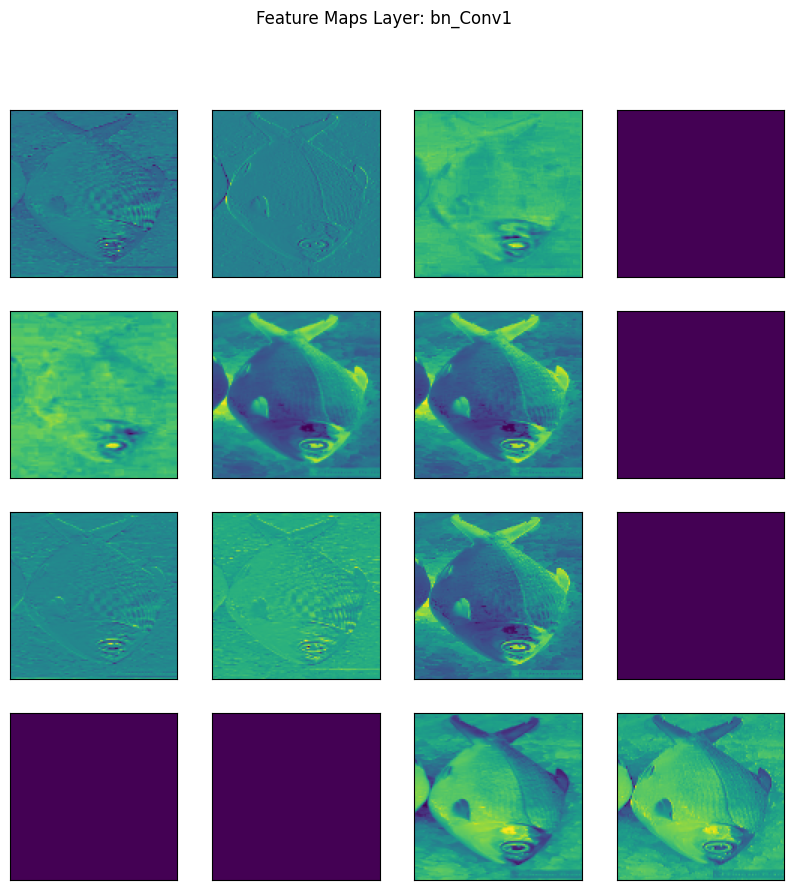

In [8]:
# --- VISUALISASI FEATURE MAPS ---

# Ambil 1 gambar
for images, labels in val_ds.take(1):
    sample_image = images[0]
    sample_label = labels[0]
    break

# Denormalisasi (karena tadi -1 s/d 1, ubah balik ke 0 s/d 1 agar bisa dilihat mata)
display_image = (sample_image + 1) / 2.0

plt.figure(figsize=(4, 4))
plt.imshow(display_image)
plt.title(f"Original: {class_names[np.argmax(sample_label)]}")
plt.axis('off')
plt.show()

# Ambil layer konvolusi pertama dari MobileNet
target_layer = base_model.layers[2]
visualization_model = models.Model(inputs=base_model.input, outputs=target_layer.output)

# Prediksi Feature Map
img_input = tf.expand_dims(sample_image, axis=0)
feature_maps = visualization_model.predict(img_input)

# Plot 16 Filter
square = 4
ix = 1
plt.figure(figsize=(10, 10))
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # Plot channel ke-ix
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='viridis')
        ix += 1
plt.suptitle(f"Feature Maps Layer: {target_layer.name}")
plt.show()